In [38]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import torch
import transformers
import sentence_transformers
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
from transformer_helper import get_token_counts, get_embeddings
from data_helper import select_first_n_occurences, main, main_2_pos_2_neg
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
col = "StoryBody"
df = main()
df0 = df.copy()
df_bis = main_2_pos_2_neg()
df_bis_sbert = df_bis.copy()

20 rows
30 rows


In [3]:
model_path = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True).to(device)

In [4]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# First example

In [5]:
df, _ = select_first_n_occurences(df, n=2)
pd.concat((df0, df), axis=1, keys=["df", "df_max_3_occ"])

df         \
                              StoryBody id_qis   
0                   This is quite rare.    id2   
1              This stock is overrated.    id1   
2          The CEO is completely crazy.    id1   
3      I would like to buy their items.    id2   
4              This stock is overrated.    id1   
5               What a surprising deal.    id1   
6                   This is quite rare.    id2   
7                     I love this firm.    id2   
8            I doubt they will make it.    id3   
9                   This is quite rare.    id2   
10          This has so much potential.    id3   
11  This new journey seems interesting.    id3   
12         The CEO is completely crazy.    id1   
13              What a surprising deal.    id1   
14              What a surprising deal.    id1   
15          This has so much potential.    id3   
16                  This is quite rare.    id2   
17           I doubt they will make it.    id3   
18           I doubt they will make it.    id3   
19     I would like to buy their items.    id2   

                           df_max_3_occ         
                              StoryBody id_qis  
0                   This is quite rare.    id2  
1              This stock is overrated.    id1  
2          The CEO is completely crazy.    id1  
3      I would like to buy their items.    id2  
4              This stock is overrated.    id1  
5               What a surprising deal.    id1  
6                   This is quite rare.    id2  
7                     I love this firm.    id2  
8            I doubt they will make it.    id3  
9                                   NaN    NaN  
10          This has so much potential.    id3  
11  This new journey seems interesting.    id3  
12         The CEO is completely crazy.    id1  
13              What a surprising deal.    id1  
14                                  NaN    NaN  
15          This has so much potential.    id3  
16                                  NaN    NaN  
17           I doubt they will make it.    id3  
18                                  NaN    NaN  
19     I would like to buy their items.    id2

In [6]:
HARD_LIMIT = 34_002
SOFT_LIMIT = 8192
token_counts = {}
embeddings = {}
cctnd_contents = {}
for id_qi in df["id_qis"].unique():
    df_id_qi = df[df["id_qis"]==id_qi]
    cctnd_content = " ".join(df_id_qi[col].to_list())
    cctnd_contents[id_qi] = cctnd_content
    token_counts[id_qi] = get_token_counts([cctnd_content], tokenizer)[0]
    assert token_counts[id_qi] <= HARD_LIMIT
    if token_counts[id_qi] >= SOFT_LIMIT:
        print(f"ID_QI {id_qi}: {token_counts[id_qi]} tokens (max. recommended is {SOFT_LIMIT})")

In [7]:
id_qis = list(cctnd_contents.keys())
embeddings = get_embeddings(list(cctnd_contents.values()), model, tokenizer, device).cpu()
embeddings = pd.DataFrame(embeddings, index=id_qis)

C:\Users\Tim\.cache\huggingface\modules\transformers_modules\Alibaba-NLP\new-impl\e244c9398934a48b4663dacf7ff4965961a6807a\modeling.py:579: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
pd.DataFrame(cosine_similarity(embeddings), index=id_qis, columns=id_qis)

,id2,id1,id3
id2,1.000000,0.346902,0.334533
id1,0.346902,1.000000,0.355955
id3,0.334533,0.355955,1.000000


In [9]:
for id_qi, content in cctnd_contents.items():
    print(f"{id_qi}: {content}")

id2: This is quite rare. I would like to buy their items. This is quite rare. I love this firm. I would like to buy their items.
id1: This stock is overrated. The CEO is completely crazy. This stock is overrated. What a surprising deal. The CEO is completely crazy. What a surprising deal.
id3: I doubt they will make it. This has so much potential. This new journey seems interesting. This has so much potential. I doubt they will make it.


# Second example

## Second example with gte (document-level)

In [10]:
df_bis, _ = select_first_n_occurences(df_bis, n=2)

In [11]:
HARD_LIMIT = 34_002
SOFT_LIMIT = 8192
token_counts = {}
embeddings = {}
cctnd_contents = {}
for id_qi in df_bis["id_qis"].unique():
    df_id_qi = df_bis[df_bis["id_qis"]==id_qi]
    cctnd_content = " ".join(df_id_qi[col].to_list())
    cctnd_contents[id_qi] = cctnd_content
    token_counts[id_qi] = get_token_counts([cctnd_content], tokenizer)[0]
    assert token_counts[id_qi] <= HARD_LIMIT
    if token_counts[id_qi] >= SOFT_LIMIT:
        print(f"ID_QI {id_qi}: {token_counts[id_qi]} tokens (max. recommended is {SOFT_LIMIT})")

In [31]:
id_qis = list(cctnd_contents.keys())
embeddings = get_embeddings(list(cctnd_contents.values()), model, tokenizer, device).cpu()
embeddings = pd.DataFrame(embeddings, index=id_qis)
res = pd.DataFrame(cosine_similarity(embeddings), index=id_qis, columns=id_qis)
id_qis.sort()
res = res.loc[id_qis, id_qis]
res

,id1,id2,id3,id5
id1,1.000000,0.306629,0.560053,0.345450
id2,0.306629,1.000000,0.513939,0.235084
id3,0.560053,0.513939,1.000000,0.226419
id5,0.345450,0.235084,0.226419,1.000000


In [32]:
# the fact that cos(i1, i3) = 0.56 is so high even though the sentiment is opposed shows that the embeddings do not convey sentiment
# i will need to extract the sentiment one way or the other
for id_qi in id_qis:
    print(f"{id_qi}: {cctnd_contents[id_qi]}")

id1: The CEO is completely crazy. This stock is overrated. This stock is overrated. The CEO is completely crazy. This is a scandal.
id2: This is quite rare. I love this firm. I love this firm. I would like to buy their items.
id3: Excellent. This is interesting. This is interesting. Excellent. Can't wait to see their new CEO! Can't wait to see their new CEO!
id5: i dislike it so much. i dislike it so much. It deserves to be ignored. It deserves to be ignored.


## Second example with sbert

In [26]:
df_bis_sbert, _ = select_first_n_occurences(df_bis_sbert, n=2)

In [27]:
embeddings = pd.DataFrame(sentence_model.encode(df_bis_sbert[col].to_list()), index=df_bis_sbert.index)
embeddings = embeddings.groupby(df_bis_sbert["id_qis"]).mean()

In [30]:
res_sbert = pd.DataFrame(cosine_similarity(embeddings), index=embeddings.index, columns=embeddings.index)
res_sbert.columns.name = res_sbert.index.name = ''
res_sbert

,id1,id2,id3,id5
,,,,
id1,1.000000,0.275946,0.438038,0.405970
id2,0.275946,1.000000,0.466192,0.195681
id3,0.438038,0.466192,1.000000,0.273799
id5,0.405970,0.195681,0.273799,1.000000


# Comparison

In [37]:
display(pd.concat((res, res_sbert), axis=1, keys=['document-level (gte)', 'sentence-level (sbert)']))
for id_qi in id_qis:
    print(f"{id_qi}: {cctnd_contents[id_qi]}")

document-level (gte)                               sentence-level (sbert)  \
                     id1       id2       id3       id5                    id1   
id1             1.000000  0.306629  0.560053  0.345450               1.000000   
id2             0.306629  1.000000  0.513939  0.235084               0.275946   
id3             0.560053  0.513939  1.000000  0.226419               0.438038   
id5             0.345450  0.235084  0.226419  1.000000               0.405970   

                                   
          id2       id3       id5  
id1  0.275946  0.438038  0.405970  
id2  1.000000  0.466192  0.195681  
id3  0.466192  1.000000  0.273799  
id5  0.195681  0.273799  1.000000

id1: The CEO is completely crazy. This stock is overrated. This stock is overrated. The CEO is completely crazy. This is a scandal.
id2: This is quite rare. I love this firm. I love this firm. I would like to buy their items.
id3: Excellent. This is interesting. This is interesting. Excellent. Can't wait to see their new CEO! Can't wait to see their new CEO!
id5: i dislike it so much. i dislike it so much. It deserves to be ignored. It deserves to be ignored.


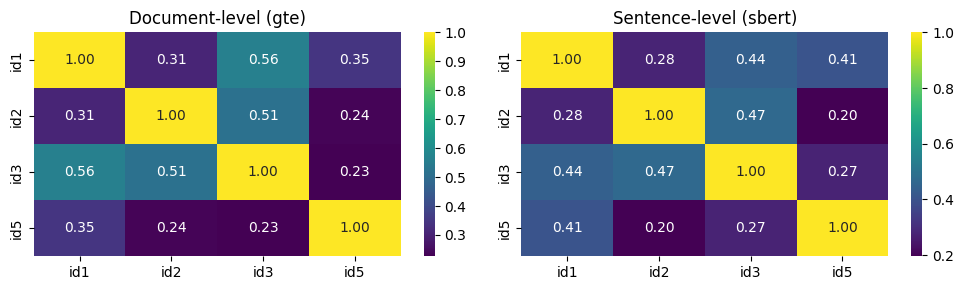

id1: The CEO is completely crazy. This stock is overrated. This stock is overrated. The CEO is completely crazy. This is a scandal.
id2: This is quite rare. I love this firm. I love this firm. I would like to buy their items.
id3: Excellent. This is interesting. This is interesting. Excellent. Can't wait to see their new CEO! Can't wait to see their new CEO!
id5: i dislike it so much. i dislike it so much. It deserves to be ignored. It deserves to be ignored.


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.heatmap(res, annot=True, fmt=".2f", cmap="viridis", ax=axes[0])
axes[0].set_title('Document-level (gte)')
sns.heatmap(res_sbert, annot=True, fmt=".2f", cmap="viridis", ax=axes[1])
axes[1].set_title('Sentence-level (sbert)')

plt.tight_layout()
plt.show()
for id_qi in id_qis:
    print(f"{id_qi}: {cctnd_contents[id_qi]}")